In [1]:
import pandas as pd
import selenium


#from data_processing.py import X_train_transform, y_train_transform

# Loading the plate datasets
full_rejected = pd.read_csv('../data/rejected_plates.csv')
full_accepted = pd.read_csv('../data/accepted_plates.csv')
reduced_plate_df=pd.read_csv('../data/full_vanity_plate_data.csv')

# TO DO: Load transformed training data from script 2!

In [2]:
import pandas as pd 
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
 
# Read in csv files and add outcome column as either "accepted" or "rejected"
# for each csv
file_path = '../data/'
filename_1 = 'accepted_plates.csv'
filename_2 = 'rejected_plates.csv'
filename_3 = 'full_vanity_plate_data.csv'

accepted_df =pd.read_csv(file_path + filename_1, index_col = 0)
accepted_df['outcome'] = 'accepted'
rejected_df = pd.read_csv(file_path + filename_2, index_col = 0)
rejected_df['outcome'] = 'rejected'

# Undersample accepted observations (by taking random sample of 2000)
reduced_accepted = accepted_df.sample(n = 2000, random_state = 415)

# tests for column addition and df join
assert reduced_accepted.shape[0] == 2000, "should be 2000 observations"
assert reduced_accepted['outcome'].all() == 'accepted', "outcome should all be 'accepted'"
assert rejected_df['outcome'].all() == 'rejected', "outcome should all be 'rejected'"

# combine dataframe and save
combo_df = reduced_accepted.append(rejected_df)
combo_df.to_csv(file_path + filename_3)

# split data into train and test sets
X = combo_df['plate']
y = combo_df['outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 415)

# test for randomization during df split
assert set(y_train) == {'accepted', 'rejected'}, "training set contains both outcomes"

# split data into train and validate sets
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size = 0.2, random_state = 415)

# feature engineering with count vectorizer
cv = CountVectorizer(analyzer='char', ngram_range=(2,8))
X_train_transformed = cv.fit_transform(X_train)

#### Exploratory data analysis (EDA)

In this section we perform EDA of the given dataset to use it to answer the research question. 

In [3]:
full_rejected['outcome'] = 'rejected'
full_accepted['outcome'] = 'accepted'

In [4]:
plate_df = full_accepted.append(full_rejected)[['date','plate','outcome']]

In [5]:
plate_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 133636 entries, 0 to 1645
Data columns (total 3 columns):
date       133636 non-null object
plate      133635 non-null object
outcome    133636 non-null object
dtypes: object(3)
memory usage: 4.1+ MB


In [6]:
plate_df.head()

,date,plate,outcome
0,2010-10-01,ANDARE,accepted
1,2010-10-01,1TWIN,accepted
2,2010-10-01,11VROD,accepted
3,2010-10-01,4SKNMC,accepted
4,2010-10-01,7IRON6,accepted


The dataset has three columns. For this project the important ones are `plate` and `outcome`. Only one value in `plate` is null or missing, which we need to eliminate in the wrangling step. Both `plate` and `outcome` are non-numeric data types. `plate` is string while `outcome` is boolean having two values `accepted` and `rejected`.

Since, the project is focused on making the predictions on the `outcome` based on `plate`, it is essential to know if we have same number of examples in the `outcome` for classification. The below plot shows the simple bar chart of the two `outcome` values. 

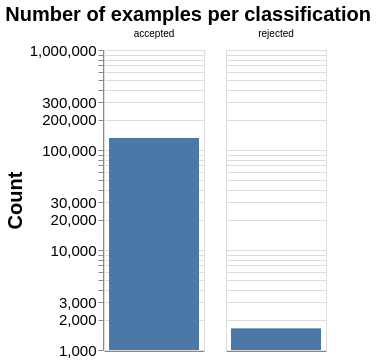

In [7]:
import altair as alt
alt.data_transformers.enable('json')

alt.Chart(plate_df).mark_bar().encode(
    alt.X("outcome:N", bin=True, axis=alt.Axis(ticks = False, labels = False, title = "")),
    alt.Y("count()", scale=alt.Scale(type='log', base=10), title = 'Count'), 
    column = alt.Column('outcome:N', title = "")
).configure_axis(labelFontSize=15,titleFontSize=20
).configure_title(fontSize=20
).properties(title="Number of examples per classification", width=100, height=300)

In [8]:
print('Total number of accepted plate is',plate_df.query('outcome == "accepted"').shape[0])
print('Total number of rejected plate is',plate_df.query('outcome == "rejected"').shape[0])

Total number of accepted plate is 131990
Total number of rejected plate is 1646


This means that we have significant class imbalance in our data. Thus, we need to account for this in our model. We will do so by undersampling the accepted plates data to 2000 examples. 

In [9]:
len(X)

3646

This leaves us with 3646 examples, 2000 for the accepted class, and 1646 for the rejected class.

After undersampling the accepted plates data, combining accepted and rejected plates into a single dataframe, and splitting the full dataset into training, validation, and testing datasets, we fit a CountVectorizer to the training data. The transformer created features of all n-grams from length 2 (minimum allowed on a plate) to the length of each example (with a maximum of 8). For example, if one example of a vanity plate submission was "CATS4EVR", 28 features would be created. Length 2 features would include `CA`, `AT`, `TS`, `S4`, `4E`, `EV`, `VR`. Length 3 would include `CAT`, `CATS`, `ATS` etc. and so on up to n-grams of length 8. 

Below is a table of the highest frequency features in the training set, where `counts` denotes how many time each n=gram appears. Higher frequency n-grams may have stronger predictive power, depending on if a frequently occurring n-gram appears disproportionately in a certain class. All of the most frequent ngrams are of length 2, which is expected given that it's more likely to that a string of 2 characters appears in multiple plates as part of longer n-grams compared to a longer string. For example, given that all plates in the dataset are unique, a string of length 8 (the maximum length) may only appear once. 

In [10]:
# Number of features
len(cv.get_feature_names())

25889

25,889 unique features were engineered from the license plates in the training dataset.

In [11]:
counts = pd.DataFrame({'ngrams':np.array(cv.get_feature_names()), 'counts': np.squeeze(np.asarray(X_train_transformed.sum(axis = 0)))})

In [12]:
# Ngrams with highest counts
counts.sort_values(by='counts', ascending = False).head(10)

,ngrams,counts
3267,88,88
4873,ar,86
12481,in,86
15133,ma,84
4642,an,82
19814,re,81
0,00,78
21684,st,77
9041,er,75
18029,on,74


Now, we'll check if any 8-character-long n-grams are repeated (which would be unexpected).

In [13]:
filter8 = counts['ngrams'].str.len()==8
counts[filter8].sort_values(by = 'counts', ascending = False).head(5)

,ngrams,counts
7,0000heke,1
17312,nypba112,1
17504,obama412,1
17576,oddododo,1
17592,odododod,1


On that note, are there any instances of repeated 7-character-long strings? Below, we see that there are only 8 instances of repeated 7-character-long strings, and the rest are unique. 

In [14]:
filter7 = counts['ngrams'].str.len()==7
counts[filter7].sort_values(by = 'counts', ascending = False).head(10)

,ngrams,counts
21842,stugots,2
12240,iiiii1i,2
3288,888b888,2
3304,88b8888,2
11813,i1111ii,2
11817,i111iii,2
5631,b88bb8b,2
17311,nypba11,2
17495,ob1229c,1
17487,oatsack,1


In [15]:
counts['ng_length'] = counts['ngrams'].str.len()

Below you'll find the distribution of n-gram frequencies for n-grams of length 2-8 (2 being the minimum length of a license plate string, 8 being the maximum). In the chart for length 2 n-grams, we see a wide distribution with some 2-character-long n-grams appearing over 80 times throughout the dataset. As we increase the length of the string, individual n-grams are repeated less often throughout the dataset which confirms the stated expected behavior from above.

In [16]:
n_g_len_chart = (alt.Chart(counts).mark_bar().encode(
        x = alt.X('counts:Q', title = "Frequency of appearance in plates", scale=alt.Scale(domain = (1,89))),
        y = alt.Y("count()", scale=alt.Scale(type='log', base=10), title = 'Count'),
        facet = alt.Facet('ng_length:N', title = 'n-gram length')
    ).properties(title = "Counts of n-grams by length", width = 500, height = 70, columns = 1))
n_g_len_chart

n_g_len_chart.save('../docs/imgs/ngram_length_counts.svg')

# The question now is: Are n-grams that appear only once in the dataset influential predictors, or should these be removed as features?

To further our exploration of our engineered features, let's examine the distribution of the most frequent n-grams between the two classes.

First, we'll group the features by length, and then pull the most common feature (by frequency count) from each length group. These are listed in the table below. 
Next, we will calculate the proportion of appearances of each high-frequency feature in each group. The results are plotted:

In [18]:
max_count_by_length = counts.sort_values(by = 'counts', ascending = False).groupby('ng_length').head(2).reset_index()
max_count_by_length

,index,ngrams,counts,ng_length
0,3267,88,88,2
1,4873,ar,86,2
2,3270,888,37,3
3,12222,iii,27,3
4,3271,8888,17,4
5,12231,iiii,12,4
6,14582,lmfao,12,5
7,3272,88888,8,5
8,24958,xkxxkx,4,6
9,3368,8b8888,3,6


In [19]:
max_count_bl_ngs = list(max_count_by_length['ngrams'])

In [20]:
top_ngrams = np.array([cv.get_feature_names().index(ng) for ng in max_count_bl_ngs])

In [30]:
df = pd.DataFrame(X_train_transformed[:,top_ngrams].todense(), columns = [cv.get_feature_names()[ng] for ng in top_ngrams])
df['outcome'] = y_train.reset_index(drop = True)

#df['ng_length'] = X_train_transformed['ngrams'].str.len()

In [31]:
ng = []
class_1 = []
p = []
ng_length = []
for col in df.columns[:-1]:
    num_per_class = df[df[col] != 0][[col, 'outcome']].groupby('outcome').count()
    ng.extend([col, col])
    class_1.extend(['accepted','rejected'])
    total_counts = sum(num_per_class[col])
    ng_length.extend([len(col), len(col)])
    if len(num_per_class.index) == 1:
        if num_per_class.index[0] == 'rejected':
            p.extend([0, num_per_class.at['rejected', col]/total_counts])
        if num_per_class.index[0] == 'accepted':
            p.extend([num_per_class.at['accepted', col]/total_counts, 0])
    else:
        p.extend([num_per_class.at['accepted', col]/total_counts, num_per_class.at['rejected', col]/total_counts])


In [32]:
df_2 = pd.DataFrame({'n-gram': ng, 'class':class_1, 'p':p, 'ng_length':ng_length})

In [34]:
df_2

,n-gram,class,p,ng_length
0,88,accepted,0.285714,2
1,88,rejected,0.714286,2
2,ar,accepted,0.738095,2
3,ar,rejected,0.261905,2
4,888,accepted,0.111111,3
5,888,rejected,0.888889,3
6,iii,accepted,0.133333,3
7,iii,rejected,0.866667,3
8,8888,accepted,0.000000,4
9,8888,rejected,1.000000,4


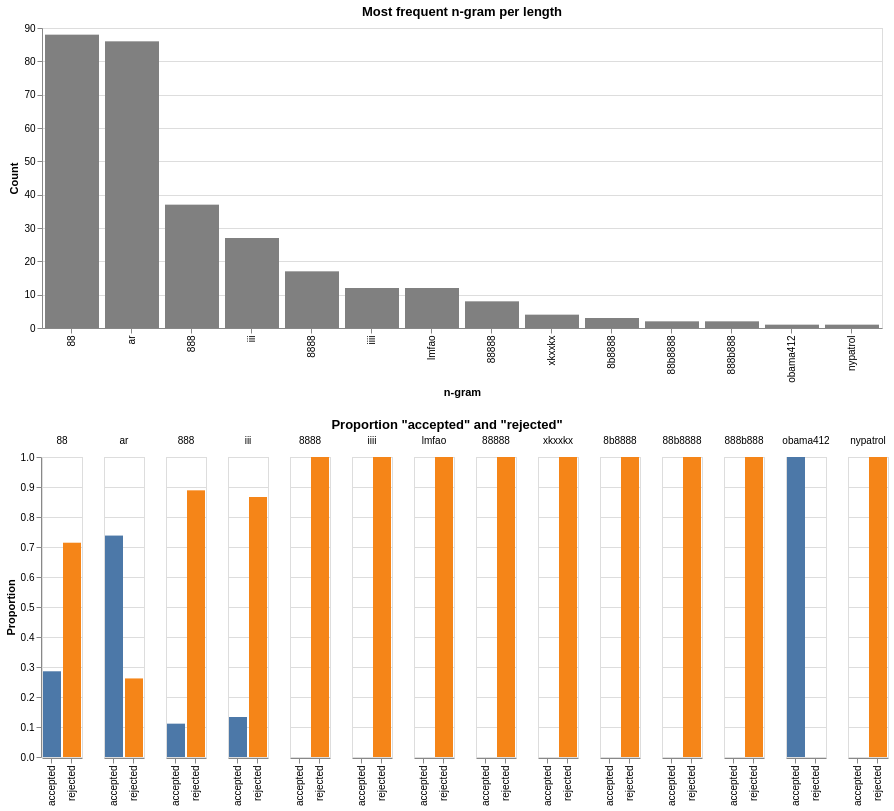

In [39]:
ngram_count = (alt.Chart(max_count_by_length).mark_bar(color = 'grey').encode(
        x = alt.X('ngrams:N', title = 'n-gram', 
                  sort = list(max_count_by_length['ngrams'])),
        y = alt.Y('counts:Q', title = 'Count')
    ).properties(title = 'Most frequent n-gram per length', width = 840))

ngram_prop = (alt.Chart(df_2).mark_bar().encode(
        x = alt.X('class:N', title = ""),
        y = alt.Y('p:Q', title = "Proportion"),
        color = alt.Color('class:N', legend = None),
        column = alt.Column('n-gram:N', 
                            sort = list(max_count_by_length['ngrams']),
                           title = "")
    ).properties(title = 'Proportion "accepted" and "rejected"', width = 40))

(ngram_count & ngram_prop).configure_title(anchor = 'middle')

It seems like frequency of a feature is not necessarily proportional to it's strength as a predictor. The features with the highest frequencies ('88', 'ar') have the most spread between classes. As frequency of an n-gram decreases, it seems more likely to appear in only a single class. This inverse relationship makes it more difficult to predict which features are the strongest predictors of a "rejected" outcome just by inspection. So let's go ahead and run the model.